In [1]:
# after implementing new envelope misfit function,
# would like to check gradient consistency
# the testdata/testsrc setup could be used for that.

In [2]:
# what we need for preparation:
# - compute the gradient for the input source
# - have a vector of smaller and smaller steps
# - have a random update to the model
# - compute m0

# what we do then for each step in the step vector:
# - scale the random update by this step
# - compute the model of the input plus the update
# - get the misfit of that model output
# - get the relative error between this misfit and m0
# - record (step,relative error)

In [3]:
import os
import numpy as np
from obspy import read
from pandas import read_csv
import h5py
from noisi import BasisFunction
import matplotlib.pyplot as plt
mtype = 'square_envelope'

NOISI toolkit
Python version: 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:39:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
mpi4py version: 3.0.0
/home/lermert/code/noisi/noisi


In [4]:
# compute the gradient for the input model
# os.system('cp -R ../test/testdata/testsrc/wavefield_processed_archived/ \
#           ../test/testdata/testsrc/wavefield_processed')
# os.system('cp ../test/testdata/testsrc/step_0/starting_model_archived.h5 \
#           ../test/testdata/testsrc/step_0/starting_model.h5')
# os.mkdir('../test/testdata/testsrc/step_0/corr')
# os.mkdir('../test/testdata/testsrc/step_0/adjt')
# os.mkdir('../test/testdata/testsrc/step_0/kern')
# os.mkdir('../test/testdata/testsrc/step_0/grad')
# os.system('cp inputs/measr_config.json ../test/testdata/testsrc/')
# os.system('cp inputs/source_config.json ../test/testdata/testsrc/')
# os.system('cp inputs/config.json ../test/testdata/')
dir = '/home/lermert/Desktop/noisi_improvements/devnoisi/src'

In [5]:
os.system('noisi correlation '+dir+' 0')
### remove output after finishing

0

In [6]:
os.system('noisi measurement '+dir+' 0')
m0 = read_csv(dir+'/step_0/'+mtype+'.0.measurement.csv')['l2_norm'][0]


print(m0)

6.42824891922e+28


In [7]:
os.system('noisi kernel '+dir+' 0') # effectively get the gradient for a 1-measurement-dataset

0

In [8]:
eps = np.arange(-4,1.5,1)

In [9]:
grad = np.load(dir+'/step_0/kern/BO.IZH..MXZ--BO.KMT..MXZ.0.npy')
grad=grad.sum(axis=1)
print(grad.shape)
direction = (np.random.random((grad.shape))-0.5)

grad += direction

b = BasisFunction('sine_taper',grad.shape[-1])
grad_expanded = np.zeros(grad.shape[0])
for i in range(grad.shape[0]):
    grad_expanded[i] = np.sum(b.expand(grad[i,:],3889))


(24764, 1)


In [10]:
m_grad = np.sum((grad_expanded))
print(m_grad)


7.42391659676e+26


In [11]:

def get_misfit_from_direction(dvec):
    os.system('rm '+dir+'/step_0/starting_model.h5')
    
    os.system('cp '+dir+'/step_0/starting_model_archived.h5 '+dir+
              '/step_0/starting_model.h5')
    f = h5py.File(dir+'/step_0/starting_model.h5','a')
    
    f['model'][:] += dvec
    f.close()

    
    os.system('rm '+dir+'/step_0/corr/*.sac')
    
    os.system('rm '+dir+'/step_0/'+
              mtype+'.0.measurement.csv')
    
    os.system('noisi correlation '+dir+' 0')
    #tr = read(dir+'/step_0/corr/*.sac')
    #corr = tr[0].data
    os.system('noisi measurement '+dir+' 0')
    msr = read_csv(dir+'/step_0/'+
                   mtype+'.0.measurement.csv')
    msr = msr['l2_norm'][0]
    
    return(msr)
    
    
    

0
9.11059722706e+25
0.877280447479
1
1.03257873341e+26
0.860911862364
2
9.68626910757e+25
0.869526159389
3
9.66328096298e+25
0.869835809211
4
9.66014925821e+25
0.869877993209
5
9.66290098362e+25
0.869840927525


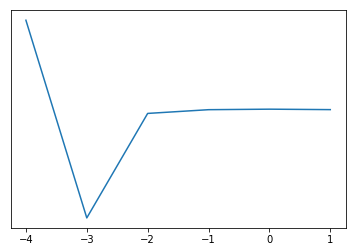

In [12]:
results = np.zeros(len(eps))
mf_a = np.zeros(len(eps))
plt.figure
for i in range(len(eps)):
    print(i)
    val = 10**eps[i]
    msr1 = get_misfit_from_direction(val*direction)
    msr2 = get_misfit_from_direction(-val*direction)
    mf_approx = 1./(2.*val)*(msr1-msr2)
    print(mf_approx)
    results[i] = np.abs(m_grad-mf_approx)/np.abs(m_grad)
    mf_a[i] = mf_approx
    print(results[i])
    #plt.plot(corr)

plt.show()
plt.semilogy(eps,results)
plt.show()

In [61]:
# removing copied files...
# os.system('rm -rf ../test/testdata/testsrc/wavefield_processed')
# os.system('rm ../test/testdata/testsrc/step_0/starting_model.h5')
# os.system('rm -rf ../test/testdata/testsrc/step_0/corr')
# os.system('rm -rf ../test/testdata/testsrc/step_0/adjt')
# os.system('rm -rf ../test/testdata/testsrc/step_0/kern')
# os.system('rm -rf ../test/testdata/testsrc/step_0/grad')
# os.system('rm ../test/testdata/testsrc/measr_config.json')
# os.system('rm ../test/testdata/testsrc/source_config.json')
# os.system('rm ../test/testdata/config.json')

0

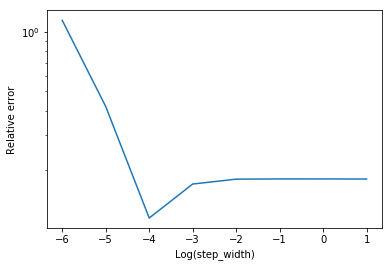

In [14]:
plt.semilogy(eps,results)
plt.xlabel('Log(step_width)')
plt.ylabel('Relative error')
plt.show()

In [13]:
7.42391659676e+26 / 9.66014925821e+25


7.685095124643687